In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

**DRA008156 Prediction**

In [2]:
# Load the clustered DRA008156 data
abundance_data = pd.read_csv('../../data/clustering/humann_clustered/clustered_complete_DRA008156.tsv', sep='\t')
meta_data = pd.read_feather('C:\\Users\\odesa\\OneDrive - University of Toronto\\CRC\\LatestDataJan\\DRA008156\\DRA008156_metadata_complete.feather')

In [3]:
meta_data = meta_data[meta_data['Accession'].isin(abundance_data['sample_id'])]

In [6]:
meta_data = meta_data[['Accession', 'Group']]

meta_data = meta_data.rename(columns={'Accession': 'sample_id'})

In [7]:
df = pd.merge(abundance_data, meta_data, on='sample_id')

# Separate features and target
X = df.drop(['Group', 'sample_id'], axis=1)
y = df['Group']

In [13]:
# Split the abundance data into training, testing, and validation sets (70/20/10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify labels

print(X_train.shape)
print(X_test.shape)

(444, 1654)
(111, 1654)


In [14]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [15]:
# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of class 1

In [21]:
# Check the order of the classes
class_order = rf_model.classes_
print("Class order in model:", class_order)

# Make predictions on the test set
y_prob = rf_model.predict_proba(X_test)

# If 'Cancer' is the second class in the order, for instance
if class_order[1] == 'Cancer':
    y_prob_cancer = y_prob[:, 1]  # Get the probability of 'Cancer'
else:
    y_prob_cancer = y_prob[:, 0]  # If 'Cancer' is the first class


Class order in model: ['Cancer' 'Healthy']


In [23]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='Cancer')
y_test_encoded = [1 if label == 'Cancer' else 0 for label in y_test]
roc_auc = roc_auc_score(y_test_encoded, y_prob_cancer)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.6846846846846847
F1 Score: 0.47761194029850745
ROC AUC: 0.73963133640553


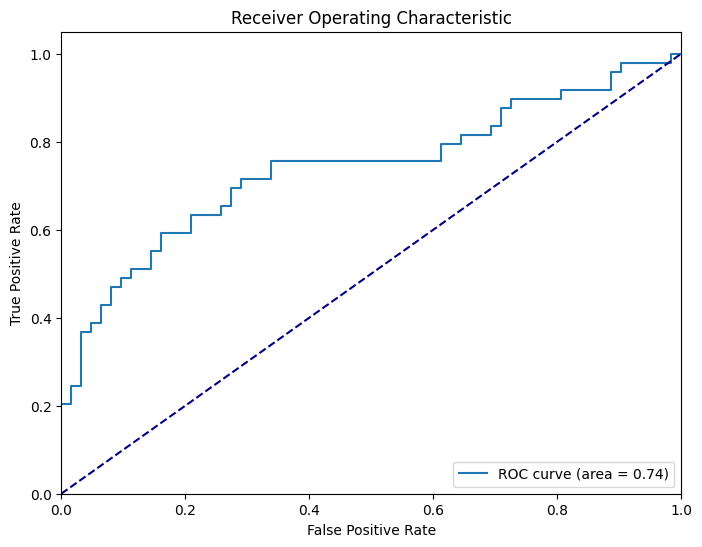

In [27]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob_cancer)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('DRA008156_cluster_roc_curve.png', dpi=300)

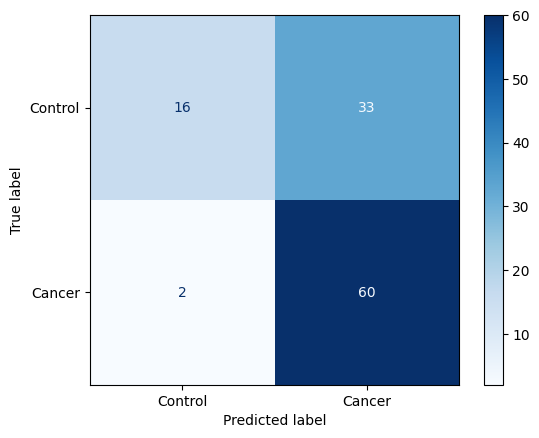

In [28]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ['Control', 'Cancer']


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('DRA008156_cluster_confusion_matrix.png', dpi=300)

In [29]:

feature_importances = rf_model.feature_importances_

feature_names = X_train.columns

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print(importances_df.head(10))

                             Feature  Importance
233                    unclustered.3    0.009109
1126           Muramidase-A0A1W6LMA8    0.008799
704               Amidase-A0A3P1V5J5    0.008242
560               Amidase-A0A1W7ABN8    0.008041
782               Amidase-A0A535X4W3    0.007658
361   DD-carboxypeptidase-A0A535ERD0    0.006826
703               Amidase-A0A3N5B293    0.006673
1418           Muramidase-A0A561DCD8    0.006125
380   DD-carboxypeptidase-A0A7C5DJG4    0.006082
899               Amidase-A0A841PWQ3    0.005636


In [ ]:
# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))

plt.title('Top 20 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

**PRJEB7774 Prediction**

In [34]:
# Load the clustered DRA008156 data
clustered_abundance_data_7774 = pd.read_csv('../../data/clustering/humann_clustered/clustered_complete_PRJEB7774.tsv', sep='\t')

abundance_data_7774 = pd.read_feather('C:\\Users\\odesa\\OneDrive - University of Toronto\\CRC\\LatestDataJan\\PRJEB7774\\clean_joined_genefamilies_relab_7774.feather')

meta_data_7774 = pd.read_feather('C:\\Users\\odesa\\OneDrive - University of Toronto\\CRC\\LatestDataJan\\PRJEB7774\\PRJEB7774_metadata.feather')

In [17]:
meta_data_7774['sample_title'].value_counts()

print(abundance_data_7774.head())

# Gene Family  sample_id  UNMAPPED  Amidase_UniRef100_A0A015SN82  \
0              ERR688505  0.994337                  6.761060e-08   
1              ERR688506  0.995306                  1.862910e-08   
2              ERR688507  0.995279                  8.390840e-09   
3              ERR688508  0.995857                  2.620490e-08   
4              ERR688509  0.995031                  0.000000e+00   

# Gene Family  Amidase_UniRef100_A0A015SSH9  Amidase_UniRef100_A0A015SVI2  \
0                              0.000000e+00                           0.0   
1                              0.000000e+00                           0.0   
2                              0.000000e+00                           0.0   
3                              1.006710e-08                           0.0   
4                              0.000000e+00                           0.0   

# Gene Family  Amidase_UniRef100_A0A015T2F2  Amidase_UniRef100_A0A015T8Q8  \
0                              7.149150e-08        

In [36]:
meta_data_7774 = meta_data_7774[meta_data_7774['run_accession'].isin(abundance_data_7774['sample_id'])]

meta_data_7774 = meta_data_7774.rename(columns={'run_accession': 'sample_id'})

df_7774 = pd.merge(abundance_data_7774, meta_data_7774, on='sample_id')

In [37]:
df_7774['sample_title'] = df_7774['sample_title'].replace({'Control': 0, 'Adenoma': 0, 'Carcinoma': 1})


In [38]:
# Separate features and target
X = df_7774.drop(['sample_title', 'sample_id'], axis=1)
y = df_7774['sample_title']

In [39]:
# Check data types of all columns
print(X.dtypes)

# Identify columns of 'object' data type
object_columns = X.select_dtypes(include=['object']).columns
print("Columns with object data type:", object_columns)

# For each object column, check unique values to understand the mix of data
for col in object_columns:
    print(f"Unique values in '{col}':", X[col].unique())

UNMAPPED                        float64
Amidase_UniRef100_A0A015SN82    float64
Amidase_UniRef100_A0A015SSH9    float64
Amidase_UniRef100_A0A015SVI2    float64
Amidase_UniRef100_A0A015T2F2    float64
                                 ...   
UC118_WP_253005939.1            float64
UC118_WP_255820014.1            float64
UC118_WP_263296879.1            float64
UC118_WP_263297069.1            float64
UC118_WP_263298109.1            float64
Length: 80748, dtype: object
Columns with object data type: Index([], dtype='object')


In [40]:
# Split the abundance data into training, testing, and validation sets (70/20/10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify labels

print(X_train.shape)
print(X_test.shape)

(108, 80748)
(47, 80748)


In [25]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

 Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [41]:
best_params =  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of class 1

In [42]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.7872340425531915
F1 Score: 0.5
ROC AUC: 0.761904761904762


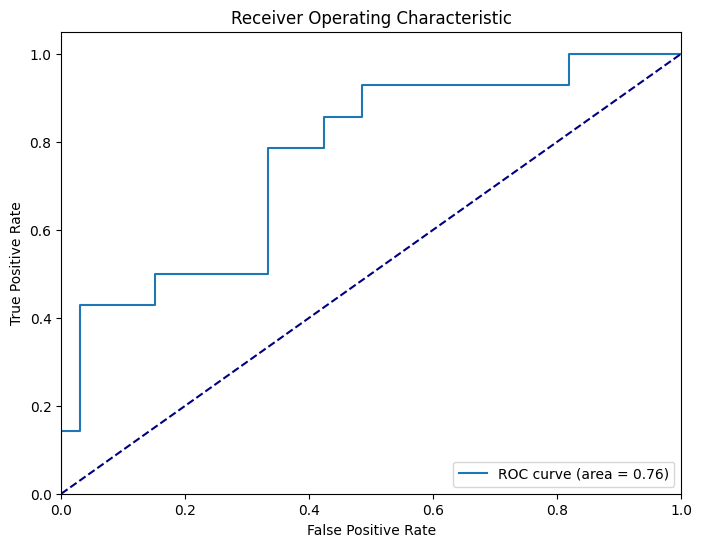

In [43]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../../figures/PRJEB7774_noCluster_roc_curve.png', dpi=300)

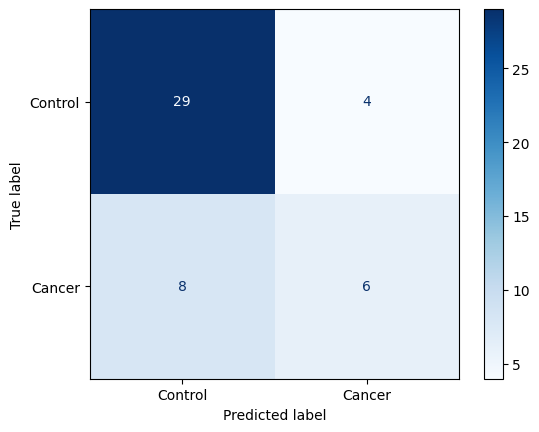

In [29]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ['Control', 'Cancer']


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('PRJEB7774_cluster_confusion_matrix.png', dpi=300)

In [20]:
column_names = abundance_data_7774.columns

column_names = [name.split('_')[0] for name in column_names]

abundance_data_7774.columns = column_names



      sample  UNMAPPED       Amidase       Amidase  Amidase       Amidase  \
0  ERR688505  0.994337  6.761060e-08  0.000000e+00      0.0  7.149150e-08   
1  ERR688506  0.995306  1.862910e-08  0.000000e+00      0.0  1.957540e-08   
2  ERR688507  0.995279  8.390840e-09  0.000000e+00      0.0  9.599790e-09   
3  ERR688508  0.995857  2.620490e-08  1.006710e-08      0.0  2.771230e-08   
4  ERR688509  0.995031  0.000000e+00  0.000000e+00      0.0  0.000000e+00   

        Amidase       Amidase       Amidase       Amidase  ...  UC118  UC118  \
0  3.498540e-07  0.000000e+00  0.000000e+00  0.000000e+00  ...    0.0    0.0   
1  2.265330e-07  0.000000e+00  0.000000e+00  0.000000e+00  ...    0.0    0.0   
2  1.268340e-07  0.000000e+00  3.218900e-07  0.000000e+00  ...    0.0    0.0   
3  1.494020e-07  1.090470e-08  0.000000e+00  1.087780e-08  ...    0.0    0.0   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...    0.0    0.0   

   UC118  UC118  UC118  UC118  UC118  UC118  UC118  UC11

In [21]:
df_combined = abundance_data_7774.groupby(by=abundance_data_7774.columns, axis=1).sum()

print(df_combined.head())

# rename the sample column


C:\Users\odesa\AppData\Local\Temp\ipykernel_12396\2079883723.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_combined = abundance_data_7774.groupby(by=abundance_data_7774.columns, axis=1).sum()


    Amidase  DD-carboxypeptidase  DD-endopeptidase  DL-endopeptidase  \
0  0.001340             0.001220          0.000204          0.000597   
1  0.001213             0.001103          0.000086          0.000448   
2  0.001110             0.001140          0.000164          0.000475   
3  0.001146             0.000882          0.000095          0.000330   
4  0.001151             0.001430          0.000098          0.000478   

   Diadenylate  Glucosaminidase  LD-carboxypeptidase  LD-endopeptidase  \
0     0.000266         0.000298             0.000161          0.000006   
1     0.000267         0.000246             0.000144          0.000015   
2     0.000273         0.000302             0.000120          0.000023   
3     0.000308         0.000380             0.000137          0.000008   
4     0.000289         0.000215             0.000115          0.000005   

   Muramidase  UC118  UNMAPPED     sample  
0    0.001571    0.0  0.994337  ERR688505  
1    0.001173    0.0  0.995306  ER

In [24]:
df_combined = df_combined.rename(columns={'sample': 'sample_id'})